In [ ]:
!pip install --upgrade statsmodels
!pip install pyramid-arima
!pip install hmmlearn

### Importing library

In [1]:

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller


from hmmlearn.hmm import GaussianHMM, MultinomialHMM

from pyramid.arima import auto_arima
from pyramid.arima import ARIMA as pyramid_arima

%matplotlib inline


In [2]:
# sns.set_style('whitegrid')
matplotlib.style.use('classic')
matplotlib.style.use('seaborn-white')
rcParams['figure.figsize'] = (16,8)

In [3]:
# import warnings
# warnings.filterwarnings(action='once')

### Defining helper functions

In [4]:
def tsplot(data, lags=None):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(311)
    ax1.plot(data)
    ax1.set_title('y_t vs. t')
    ax1.minorticks_on()
    ax1.grid(which='both')
    ax2 = fig.add_subplot(312)
    ax2.minorticks_on()
    ax2.grid(which='both')
    sm.graphics.tsaplots.plot_acf(data, lags=lags, ax=ax2) 
    ax3 = fig.add_subplot(313)
    ax3.minorticks_on()
    ax3.grid(which='both')
    sm.graphics.tsaplots.plot_pacf(data, lags=lags, ax=ax3) 
#     fig.show()
    return fig

In [5]:
def test_stationarity(timeseries, window_size):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd = timeseries.rolling(window_size).std()


    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=2)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=2)
    plt.grid()
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.values.flatten(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

### Importing data

In [6]:
data = pd.read_json('../input/eth-donation-requests.json')

### Wrangling data

In [7]:
data.loc[:,'tagged_begging'] = pd.to_datetime(data.loc[:,'tagged_begging'])

In [8]:
data.head()

,tagged_begging
0,2018-01-01 20:13:18
1,2018-01-01 20:16:10
2,2018-01-01 20:16:37
3,2018-01-01 20:16:36
4,2018-01-01 20:26:21


In [9]:
data.describe()

,tagged_begging
count,93142
unique,92265
top,2018-02-12 11:16:53
freq,3
first,2018-01-01 20:12:16
last,2018-04-13 18:57:38


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
tagged_begging    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.7 KB


In [11]:
begg_freq_data = (data.resample('15min',on='tagged_begging')
                      .count().rename(columns={'tagged_begging':'count'})
                      .rename_axis('time'))

In [12]:
begg_1h_data = (data.resample('1h',on='tagged_begging')
                    .count().rename(columns={'tagged_begging':'count'})
                    .rename_axis('time'))

In [13]:
begg_4h_data = (data.resample('4h',on='tagged_begging')
                    .count().rename(columns={'tagged_begging':'count'})
                    .rename_axis('time'))

In [14]:
begg_12h_data = (data.resample('12h',on='tagged_begging')
                     .count().rename(columns={'tagged_begging':'count'})
                     .rename_axis('time'))

In [15]:
begg_day_data = (data.resample('1D',on='tagged_begging')
                     .count().rename(columns={'tagged_begging':'count'})
                     .rename_axis('time'))

## 1. Exploratory Data Analysis

#### Looking at begging data at different time scales

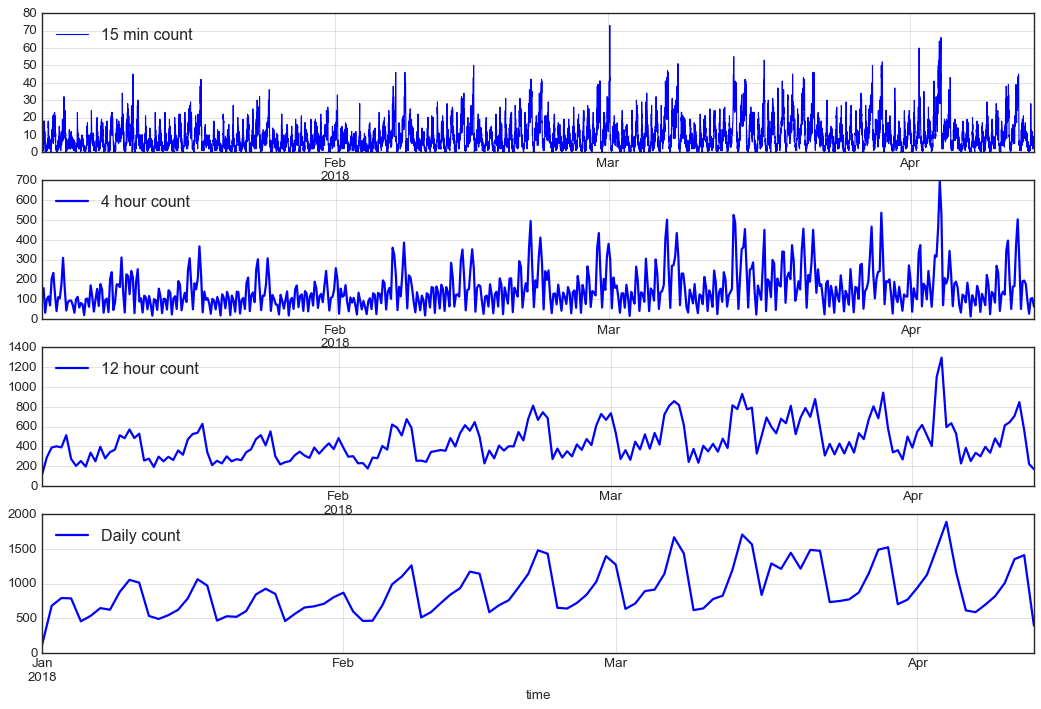

In [16]:
fig = plt.figure(figsize=(16,10));
ax1, ax2, ax3, ax4 = fig.subplots(4,1)
begg_freq_data.rename(columns={'count':'15 min count'}).plot(ax=ax1, linewidth=1, grid=True);
begg_4h_data.rename(columns={'count':'4 hour count'}).plot(ax=ax2, linewidth=2, grid=True);
begg_12h_data.rename(columns={'count':'12 hour count'}).plot(ax=ax3, linewidth=2, grid=True);
begg_day_data.rename(columns={'count':'Daily count'}).plot(ax=ax4, linewidth=2, grid=True);

**Some notes on above plots:**
* The data looks stationary, however further checks will be conducted later to confirm this.
* The data includes from seasonility (periodicity). The seasonal frequacy will be found below.

#### Next let's look at the shape of the distribution of daily counts:

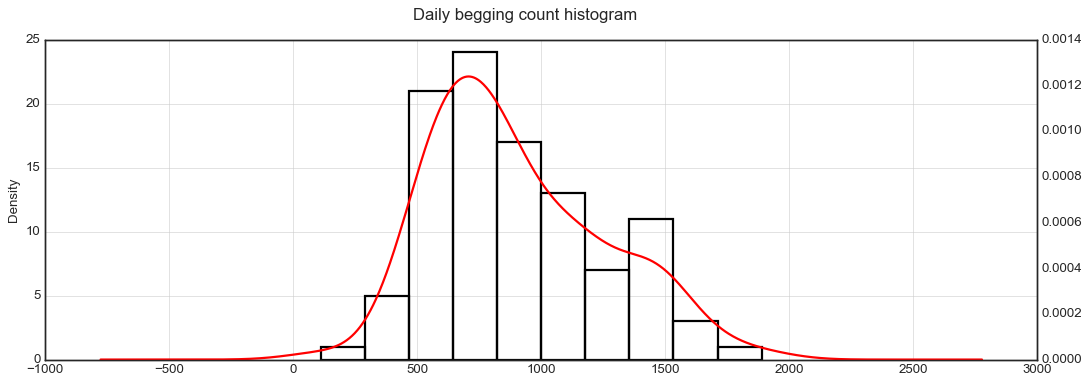

In [17]:
fig = plt.figure(figsize=(16,5))
ax = fig.subplots()
begg_day_data.plot.hist(bins=10, ax=ax,linewidth=2, grid=True, legend=False,fill=False);
begg_day_data.plot.kde(color='red', ax=ax, secondary_y=True,linewidth=2, grid=True, legend=False);
fig.suptitle('Daily begging count histogram', fontsize=15);

**Note on the histogram plot:** It looks like most days have 600 to 800 begging requests

#### Now let's take a look at the hourly, day of week, and day of month variation of the begging requests:

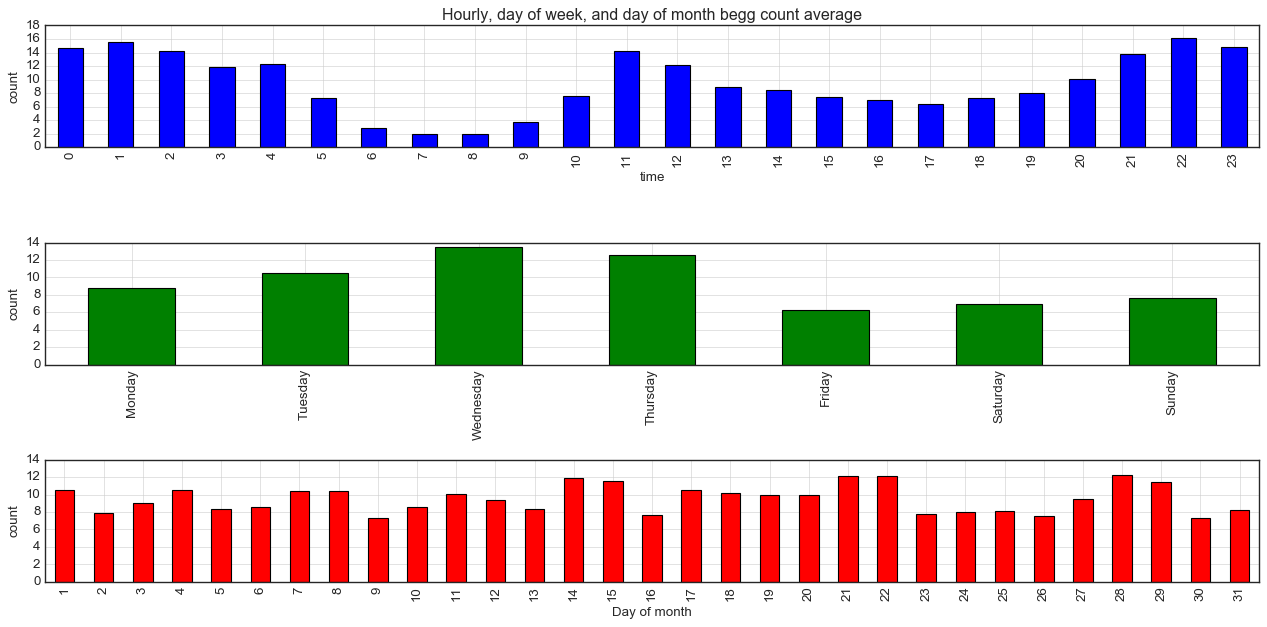

In [18]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1)
hourly_average = begg_freq_data.groupby(begg_freq_data.index.hour).mean()
hourly_average.plot.bar(ax=ax1, color='blue', grid=True, legend=False,
                        title='Hourly, day of week, and day of month begg count average')
hourly_average.index.rename('Hour of day', inplace=True)
days_index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
day_of_week_average = begg_freq_data.groupby(begg_freq_data.index.dayofweek).mean()
day_of_week_average.index.rename('Day of week', inplace=True)
day_of_week_average.index = days_index
day_of_week_average.plot.bar(ax=ax2, color='green', grid=True, legend=False)
day_of_month_average = begg_freq_data.groupby(begg_freq_data.index.day).mean()
day_of_month_average.index.rename('Day of month', inplace=True)
day_of_month_average.plot.bar(ax=ax3, color='red', grid=True, legend=False)
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('count')
fig.tight_layout()

**Notes on above plots:**
* The begging request activity has an obvious daily cycle which significantly drops daily between 5 am to 10 am. This might be due to the time that "begger" sleeps in his/her local time zone of the.
* The number of requests increases from Sunday to Thursday and then their count significantly drops on Friday and Saturday.
* The Day of month begging activity shows a clear weekly periodicity.

#### Next, let's look at box and whisker plots of daily, weekly, and monthly request activity:

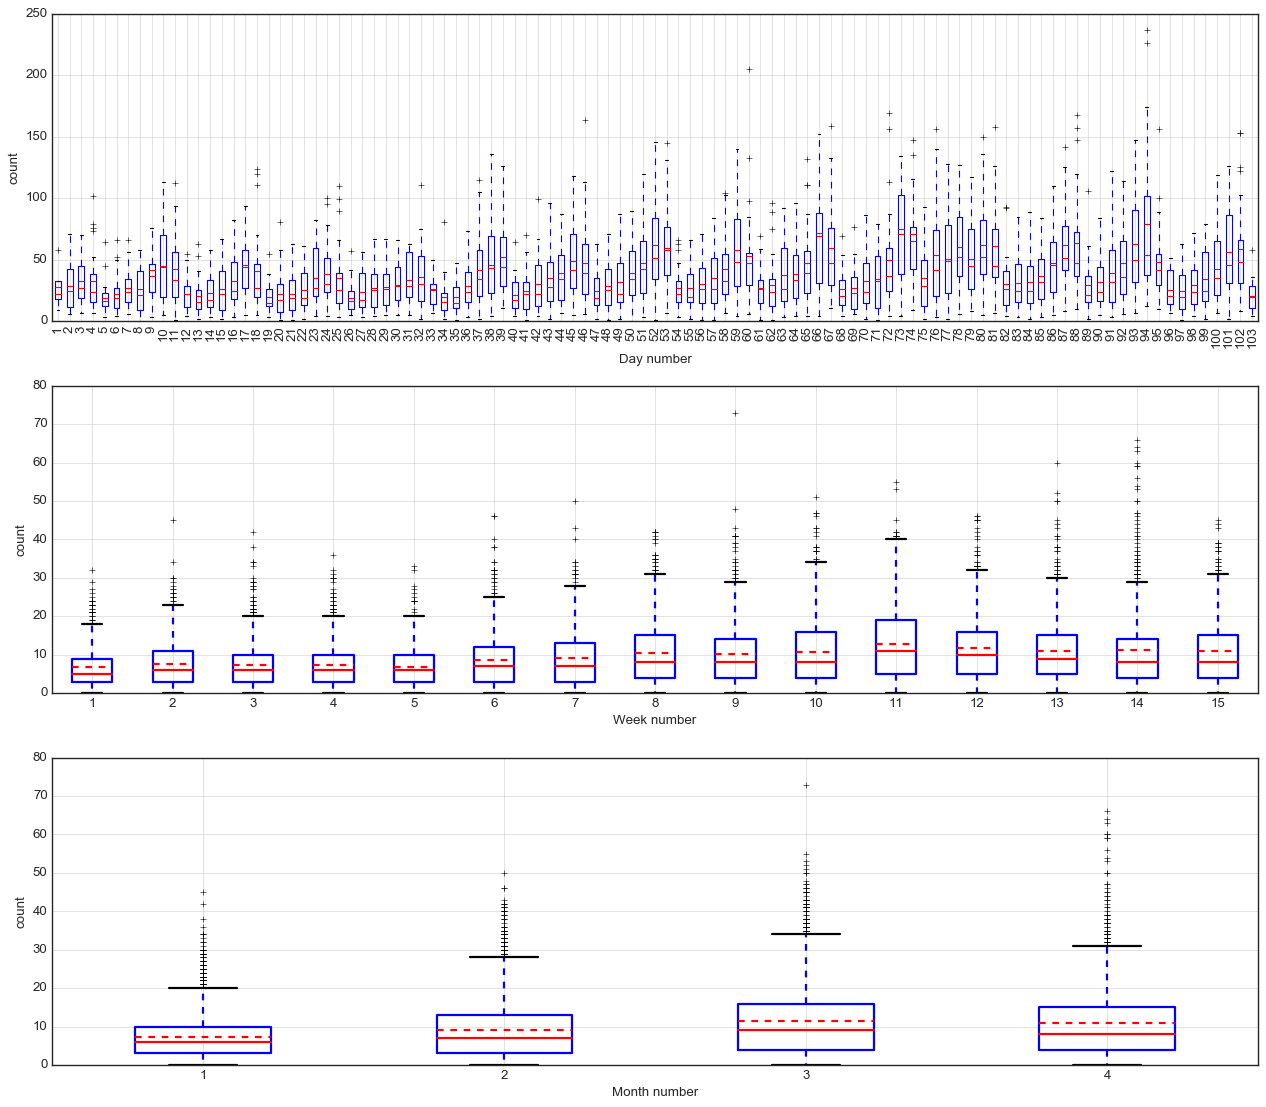

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(16, 14))
groups = begg_1h_data.groupby(pd.Grouper(freq='D'))
days = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
days = pd.DataFrame(days)
days.columns = range(1,len(groups)+1)
days.boxplot(ax=ax1, rot=90,meanline=True, showmeans=True, 
             capprops={'linewidth':1}, 
             whiskerprops={'linewidth':1}, 
             medianprops={'linewidth':1}, 
             meanprops={'linewidth':1, 'linestyle':'--'}, 
             boxprops={'linewidth':1}, 
             showfliers=True, sym='+',flierprops={'linewidth':1});
ax1.set_xlabel('Day number')
ax1.set_ylabel('count')
groups = begg_freq_data.groupby(pd.Grouper(freq='W'))
weeks = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
weeks = pd.DataFrame(weeks)
weeks.columns = range(1,16)
weeks.boxplot(ax=ax2, meanline=True, showmeans=True, 
              capprops={'linewidth':2}, 
              whiskerprops={'linewidth':2},
              medianprops={'linewidth':2}, 
              meanprops={'linewidth':2, 'linestyle':'--'}, 
              boxprops={'linewidth':2}, 
              showfliers=True, sym='+',flierprops={'linewidth':2});
ax2.set_xlabel('Week number')
ax2.set_ylabel('count')
groups = begg_freq_data.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,5)
months.boxplot(ax=ax3, meanline=True, showmeans=True, 
               capprops={'linewidth':2}, 
               whiskerprops={'linewidth':2}, 
               medianprops={'linewidth':2}, 
               meanprops={'linewidth':2, 'linestyle':'--'}, 
               boxprops={'linewidth':2}, 
               showfliers=True, sym='+',flierprops={'linewidth':2});
ax3.set_xlabel('Month number')
ax3.set_ylabel('count')
fig.tight_layout()

**Notes on above plots:**
* Our intial assumption regarding weekly periodicity of the begging request is clear from the top plot
* There is an underlying trend in weekly activity

#### Let's take another quick look at the hour of day activity of request:

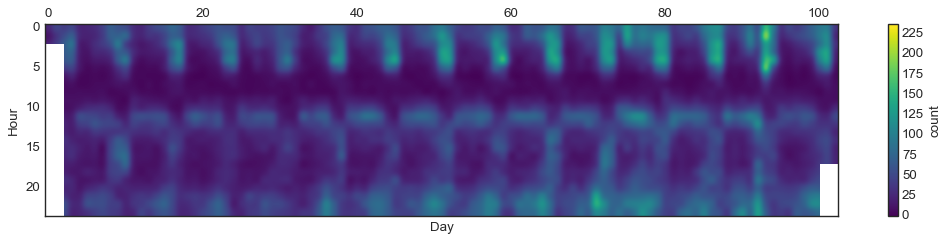

In [20]:
fig = plt.figure(figsize=(16,3))
ax = fig.subplots()
dm = ax.matshow(days, interpolation='gaussian', aspect='auto', cmap=plt.cm.viridis);
ax.set_xlabel('Day')
ax.set_ylabel('Hour')
cbar = plt.colorbar(dm);
cbar.set_label('count')

**Comment:** We can see that the dark patches between 5 to 10 am is consistent for all days, however, the activity on all other days follows the similar previously discussed weekly pattern. This again confirms the idea for the sleeping time of the "begger".

In [21]:
# fig = plt.figure()
# ax1 = fig.add_subplot(131)
# ax1.matshow(days.T, interpolation='nearest', aspect='auto', cmap=plt.cm.viridis);
# ax2 = fig.add_subplot(132)
# ax2.matshow(weeks.T, interpolation='bilinear', aspect='auto', cmap=plt.cm.viridis);
# ax3 = fig.add_subplot(133)
# ax3.matshow(months.T, interpolation='gaussian', aspect='auto', cmap=plt.cm.viridis);

#### Next, let's dive deeper to accurately identify the periodicity of the begging requests using lag and autocorrelation plots:

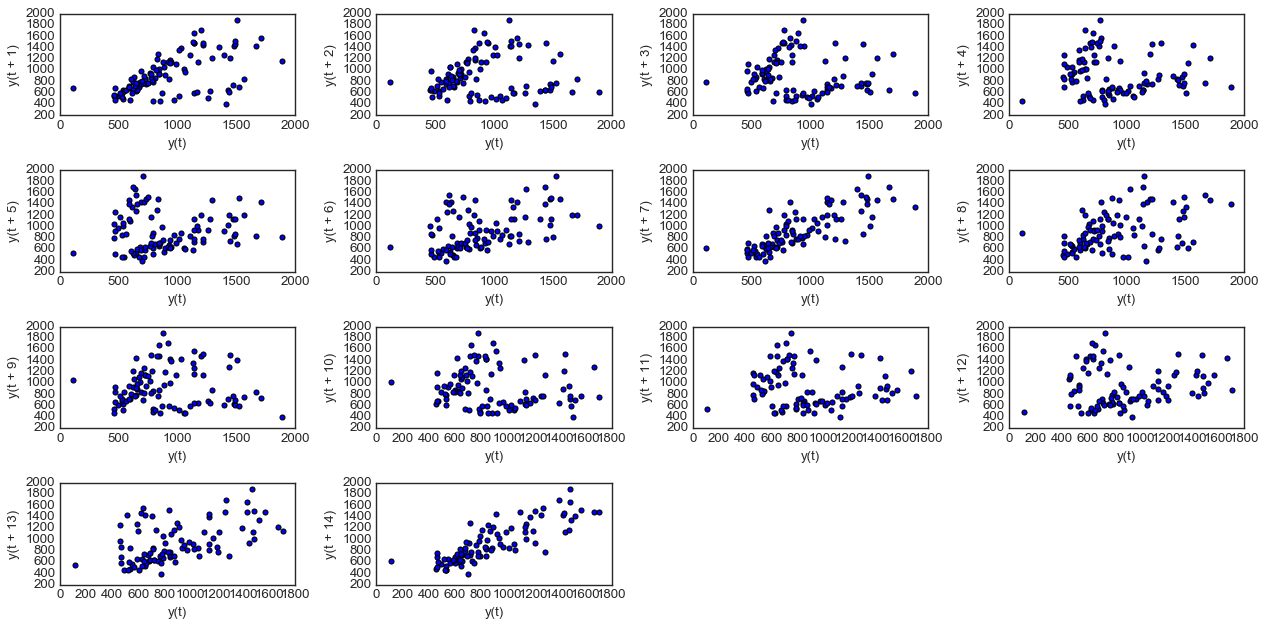

In [22]:
lags = 14
for i in range(1,(lags + 1)):
    ax = plt.subplot(4, 4, i)
    pd.plotting.lag_plot(begg_day_data, lag=i);
plt.tight_layout()

These plots show strong relationships between an observation with its previous value and its value in the previous week.

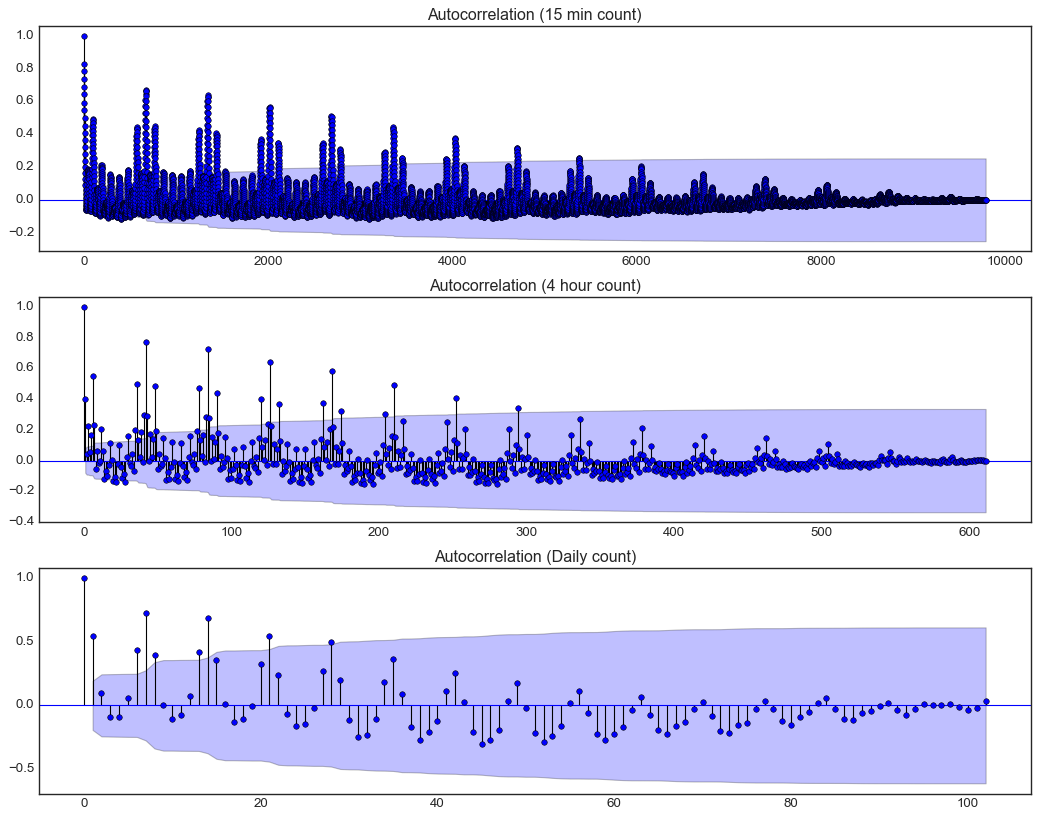

In [23]:
fig = plt.figure(figsize=(16,12));
ax1 = fig.add_subplot(311);
sm.graphics.tsaplots.plot_acf(begg_freq_data, lags=None, ax=ax1);
ax1.set_title('Autocorrelation (15 min count)');
ax2 = fig.add_subplot(312);
sm.graphics.tsaplots.plot_acf(begg_4h_data, lags=None, ax=ax2);
ax2.set_title('Autocorrelation (4 hour count)');
ax3 = fig.add_subplot(313);
sm.graphics.tsaplots.plot_acf(begg_day_data, lags=None, ax=ax3);
ax3.set_title('Autocorrelation (Daily count)');

These plots also show the daily and weekly periodicity of the requestes with stronger correlation at weekly periods.

### Next, let's take a final look at the trend and seasonal component separately:

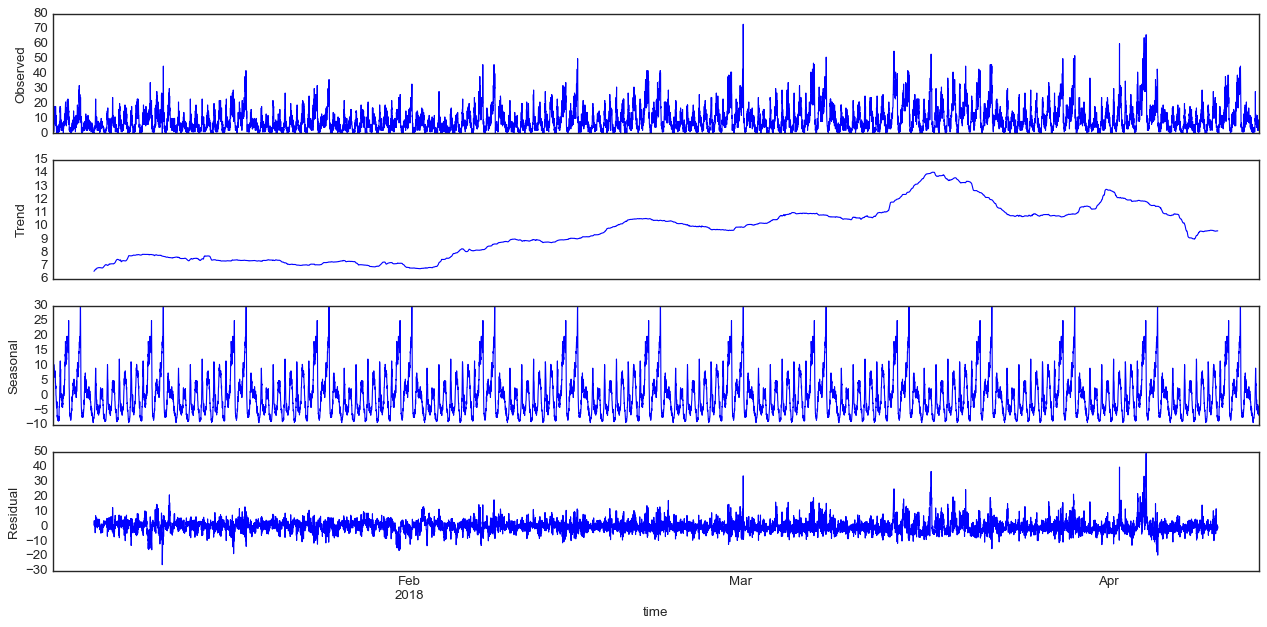

In [24]:
decompfreq = 24*60/15*7
decomposition = sm.tsa.seasonal.seasonal_decompose(begg_freq_data, freq=decompfreq)
decomposition.plot();

In [25]:
# decompfreq = 24*7
# decomposition = sm.tsa.seasonal.seasonal_decompose(begg_1h_data, freq=decompfreq)
# decomposition.plot();

In [26]:
# decomposition = sm.tsa.seasonal.seasonal_decompose(begg_day_data)
# decomposition.plot();

In [27]:
# decomposition = sm.tsa.seasonal.seasonal_decompose(begg_day_data, model='multiplicative')
# decomposition.plot();

In [28]:
# mod_cycle = sm.tsa.statespace.structural.UnobservedComponents(begg_4h_data,
# #                                                               level='local linear trend',
# #                                                                ar=none,
#                                                                level=True,
# #                                                                cycle=True, 
# #                                                                trend=True,
#                                                                irregular=True,
#                                                                seasonal=7*2*3,
#                                                                stochastic_level=True,
# #                                                                freq_seasonal=[{'period':14}]
# #                                                                stochastic_trend=True
# #                                                                stochastic_cycle=True,
# #                                                                damped_cycle=True
#                                                               )
# res_cycle = mod_cycle.fit()
# print res_cycle.summary()
# fig_cycle = res_cycle.plot_components()

### Final conlusions from EDA:
* Begging requests have daily and weekly periodicity
* There is a sudden increase in the number of requests in the begining of April!

## 2. Modeling the begging activity

###### **First let's make sure the time series data is stationary using:**
1. One week rolling mean and std plot
2. Augmented Dickey-Fuller Test

In [29]:
s = 7*24*60/15
h = s
n_h = 4
observed = begg_freq_data#[-5*n_h*h:]
train = observed[:-n_h*h]
test = observed[-n_h*h:]

In [30]:
forecast_time = pd.date_range(observed.index[-1] + observed.index.freq, periods=4, freq=observed.index.freq)

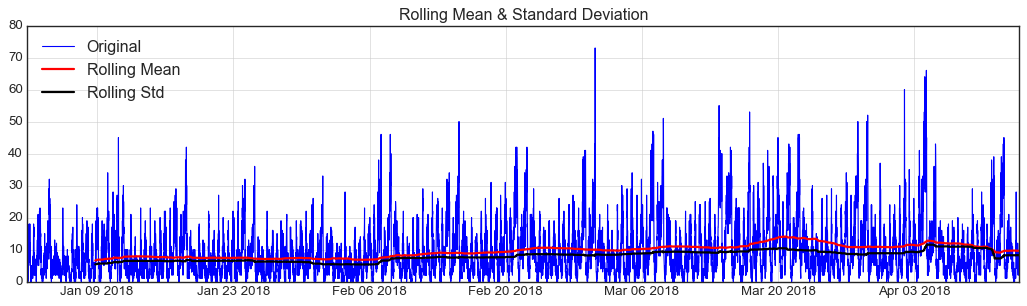

Results of Dickey-Fuller Test:
Test Statistic                -1.033795e+01
p-value                        2.732397e-18
# Lags Used                    3.800000e+01
Number of Observations Used    9.749000e+03
Critical Value (5%)           -2.861837e+00
Critical Value (1%)           -3.431021e+00
Critical Value (10%)          -2.566928e+00
dtype: float64


In [31]:
test_stationarity(begg_freq_data, window_size=s);

**Notes on the stationary test:**
* Data is stationary when excluding the seasonal effect.
* A trend exist in the data (As also seen in the decomposition plot above).
* Data has periodicity (found above).
* Variance is stable.

##### Next we will model our time series data using: 
1. Holt Winter’s Exponential Smoothing
2. Seasonal ARIMA
3. Random Forest Regression

**Creating train and test data**

##### 1. Holt Winter’s Exponential Smoothing

In [32]:
ets_model = sm.tsa.holtwinters.ExponentialSmoothing(train ,seasonal_periods=s ,
                                                    trend='add', seasonal='add')
ets_result = ets_model.fit()

**Model performance and predicting the begging activity for the following hour:**

None
AIC		19803.964
AICc		19946.964
BIC		24446.63
SSE		95484.401
OOB R^2		0.506

Next hour activity:
2018-04-13 19:00:00    8.045574
2018-04-13 19:15:00    8.644469
2018-04-13 19:30:00    8.379319
2018-04-13 19:45:00    9.307797
Freq: 15T, dtype: float64


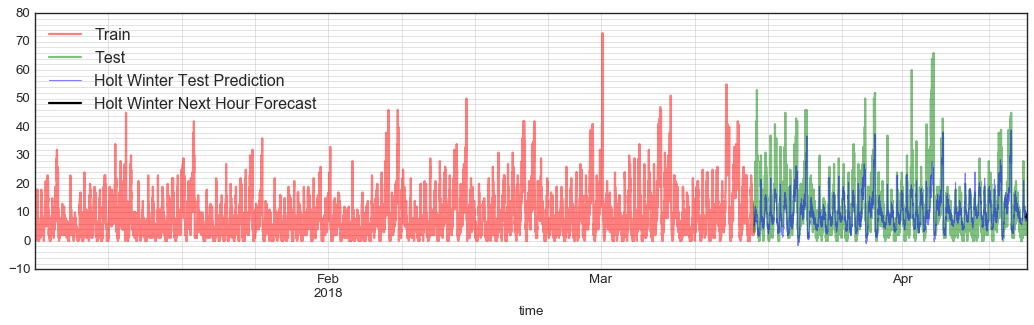

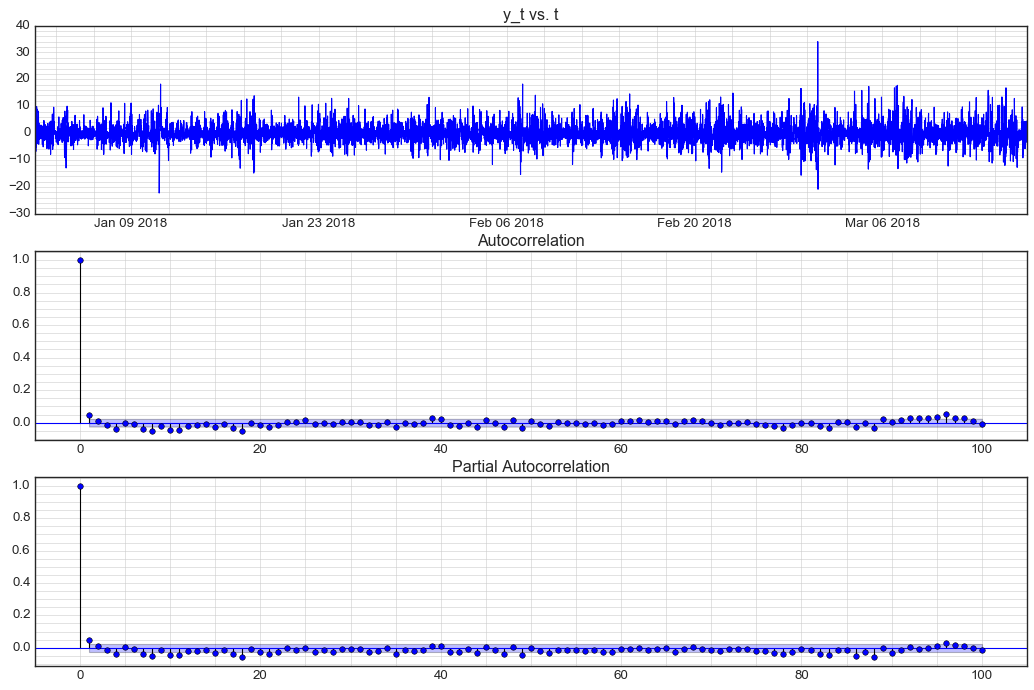

In [33]:
print ets_result.summary()
print 'AIC\t\t', round(ets_result.aic,3)
print 'AICc\t\t', round(ets_result.aicc,3)
print 'BIC\t\t', round(ets_result.bic,3)
print 'SSE\t\t', round(ets_result.sse,3)
ets_test_prediction = ets_result.forecast(len(test))
print 'OOB R^2\t\t', round(r2_score(test, ets_test_prediction),3)
ets_forecast = ets_result.forecast(len(test) + len(forecast_time))
print
print 'Next hour activity:'
print ets_forecast[len(test):]
fig, ax = plt.subplots(figsize=(16,4))
train.rename(columns={'count':'Train'}).plot(c='red', alpha=.5, ax=ax, lw=2)
test.rename(columns={'count':'Test'}).plot(c='green', alpha=.5, ax=ax, lw=2)
ets_test_prediction.plot(c='blue', alpha=0.5,ax=ax, label='Holt Winter Test Prediction')
ets_forecast[len(test):].plot(c='black', ax=ax, label='Holt Winter Next Hour Forecast', lw=2)
ax.minorticks_on()
plt.legend(loc='best')
plt.grid(which='both')
tsplot(ets_result.resid, lags=100);
# plt.show()

In [34]:
errors = []
tscv = TimeSeriesSplit(n_splits=3) 
for train_cv, test_cv in tscv.split(train):
    ets_model = sm.tsa.holtwinters.ExponentialSmoothing(train.iloc[train_cv] ,seasonal_periods=s ,
                                                        trend='add', seasonal='add')
    ets_result = ets_model.fit()
    errors.append(ets_result.sse/len(train_cv))
print 'Cross-validated averaged Mean Squared Error for Holt Winter’s Exponential Smoothing = ', str(round(np.mean(np.array(errors)),3)).strip()

Cross-validated averaged Mean Squared Error for Holt Winter’s Exponential Smoothing =  9.934


#### 2. Seasonal ARIMA
**Identifying the model:** We use ACF and PACSF plots to identify the parameters.

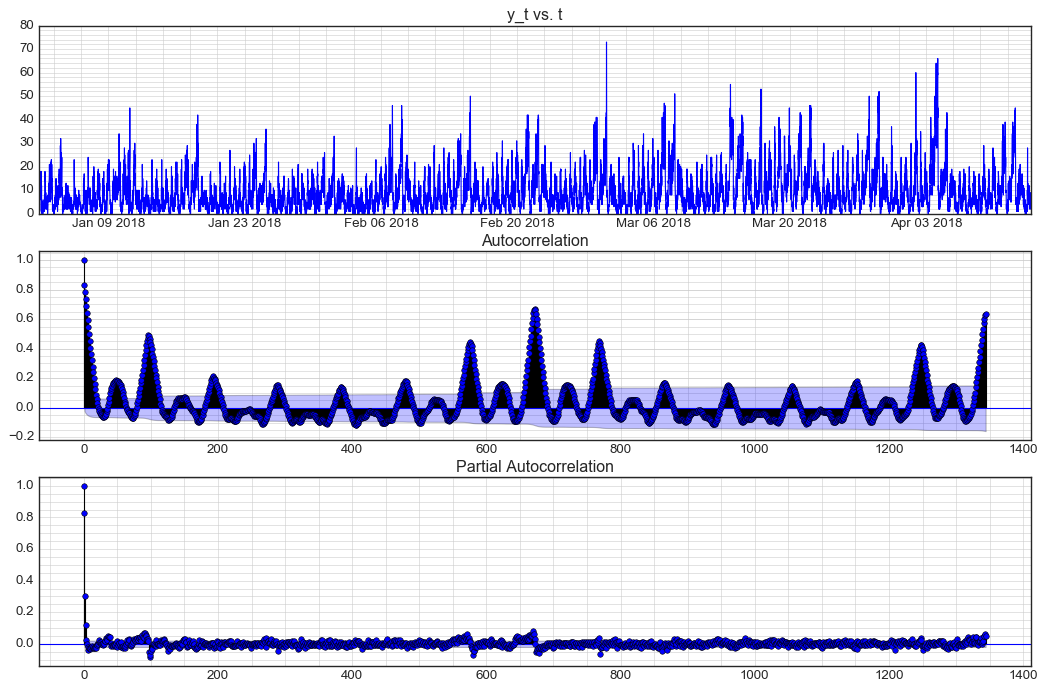

In [35]:
tsplot(begg_freq_data, lags=2*s);

In [36]:
# tsplot(begg_1h_data, lags=None);
# tsplot(begg_4h_data, lags=6*7*2);
# tsplot(begg_12h_data, lags=None);
# tsplot(begg_day_data, lags=None);

#### Checking the first order differencing for removing the trend:

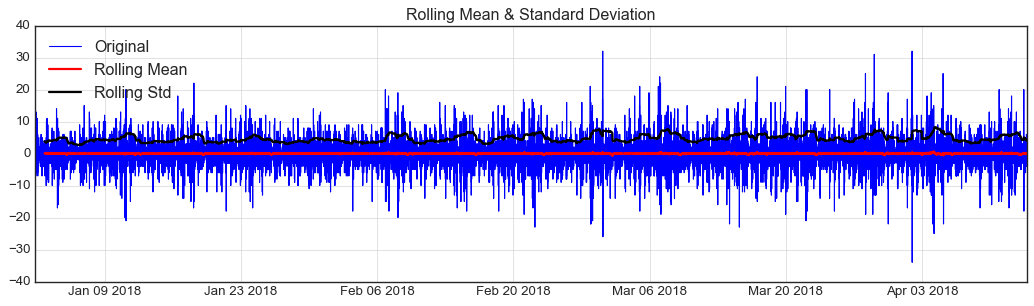

Results of Dickey-Fuller Test:
Test Statistic                  -28.872915
p-value                           0.000000
# Lags Used                      38.000000
Number of Observations Used    9748.000000
Critical Value (5%)              -2.861837
Critical Value (1%)              -3.431021
Critical Value (10%)             -2.566928
dtype: float64


In [37]:
test_stationarity(begg_freq_data.diff(1)[1:], window_size=s/7);

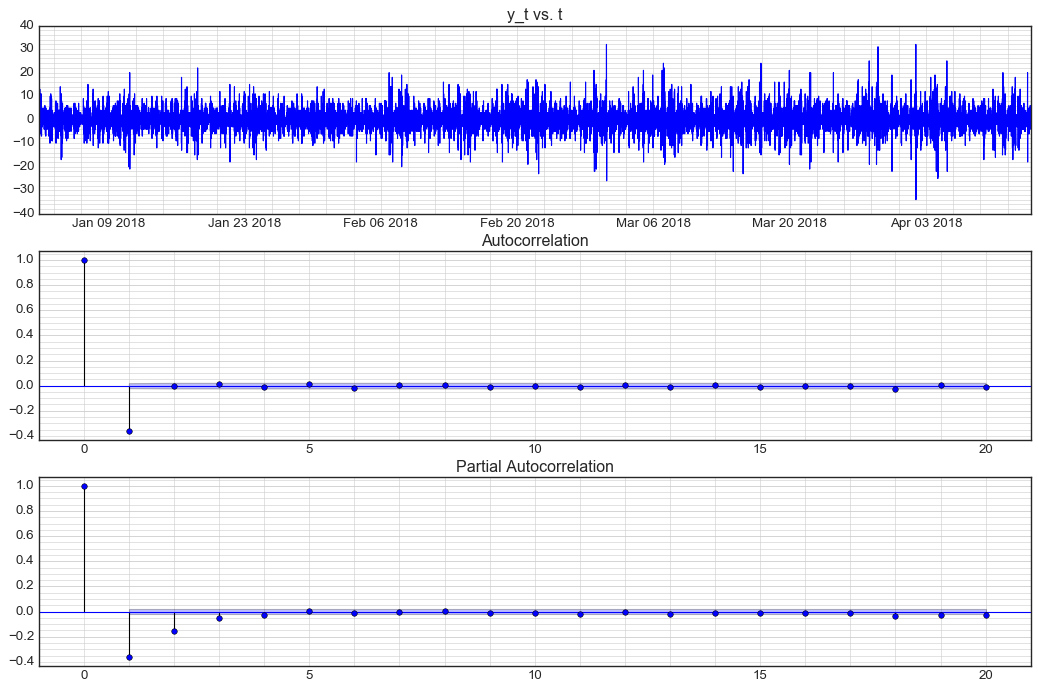

In [38]:
tsplot(begg_freq_data.diff()[1:], lags=20);

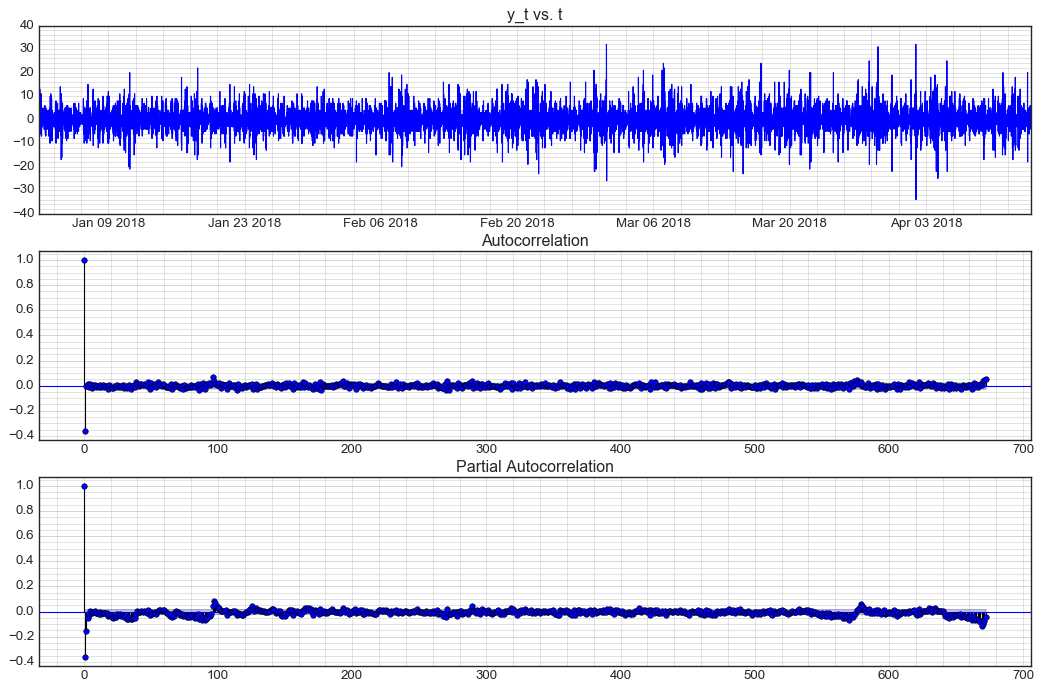

In [39]:
tsplot(begg_freq_data.diff()[1:], lags=s);

#### Here is the list possible canidate model parameters found from ACF/PACF plots:
* p = 2 : Largest lag in PACF after d times differenced
* d = 1 : Making the time series stationary
* q = 1 : Largest lag in ACF after d times differenced

* s = 7 days
* P = 1 : d times differenced ACF is positive at lag s
* I = 0 : Seasonal activity is not very strong
* Q = 0 : Not needed (Q=1 from auto-arima)

We can either do a manual grid search for the best model prameters around the above values using AICc, or we can let auto-arima do it for us. Let's try the latter :)

**IMPORTANT NOTE:** Due to the large periodicity values of data at 15 minutes frequency granular level, modeling it using auto-arima and Seasonal ARIMA (SARIMAX) becomes computationally intestive (at least too intensive for my computing resources). So I decided to skip the modeling using Seasonal ARIMA.

### In case if we really want to use Seasonal ARIMA: Run the following script
```python
aa_model = auto_arima(train, 
                      start_p=0, 
                      start_q=0,
                      max_p=3,
                      max_q=3,
                      d=1,                     
                      m=s,
                      start_P=0,
                      start_Q=0, 
                      max_P=0,
                      max_Q=0,
                      seasonal=True,
                      n_jobs=-1, 
                      trace=True,
                      disp=True,
                      error_action='ignore',
                      suppress_warnings=True, 
                      information_criterion = 'aicc',
                      stepwise=False
                     )
print aa_model.aic()
print aa_model.summary()

sm_model=sm.tsa.statespace.sarimax.SARIMAX(train, order=aa_model.order, 
                                           seasonal_order=aa_model.seasonal_order
                                          )
sm_result = sm_model.fit()
print sm_result.summary()
# The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
sm_result.plot_diagnostics(figsize=(16, 10));
plt.tight_layout();

tsplot(sm_result.resid, lags=100);

fig, ax = plt.subplots(figsize=(16,4))
# train.rename(columns={'count':'Train'}).plot(c='red', alpha=.5, ax=ax, lw=2)
# test.rename(columns={'count':'Test'}).plot(c='black', alpha=.5, ax=ax, lw=2)
observed.rename(columns={'count':'Observed'}).plot(c='red', ax=ax, alpha=.5, lw=2)
sm_pred = sm_result.get_prediction()
sm_pred_ci = sm_pred.conf_int()
sm_pred.predicted_mean.plot(c='green', alpha=0.5, ax=ax, label='Train Prediction', lw=2)
# ax.fill_between(sm_pred_ci.index, 
#                 sm_pred_ci.iloc[:, 0], 
#                 sm_pred_ci.iloc[:, 1], color='green', alpha=.25, lw=2);
# sm_pred = sm_result.predict()
# sm_pred.plot(c='green', alpha=0.5, ax=ax, label='Train Prediction', lw=2)
sm_forecast = sm_result.get_forecast(len(test))
sm_forecast_ci = sm_forecast.conf_int()
sm_forecast.predicted_mean.plot(ax=ax, label='Test Forecast', 
                                alpha=.7, color='blue', lw=2);
ax.fill_between(sm_forecast_ci.index, 
                sm_forecast_ci.iloc[:, 0], 
                sm_forecast_ci.iloc[:, 1], color='blue', alpha=.25);
ax.minorticks_on()
plt.legend(loc='best')
plt.grid(which='both')
```

#### 3. Random Forest Regression
Next we will model the data using the Random Forest Regressor and will forecast the next hour activity. I pick a random forest cause: it usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. I will use the random forest to predict request activity, then I will use partial dependence plots and variable importance to get insights about how it got information from the variables.

#### Feature exctraction:
Creating features based on previous hour, previous day, and previous week data.

In [40]:
data = pd.DataFrame(begg_freq_data.copy())
data.columns = ["y"]
for i in range(5, 9):
    data["lag_{}".format(i)] = data.y.shift(i)
for i in range(93, 97):
    data["lag_{}".format(i)] = data.y.shift(i)
for i in range(s-3, s+1):
    data["lag_{}".format(i)] = data.y.shift(i)
# data['weeks'] = observed.index.week
# data['months'] = observed.index.month
# data['days'] = observed.index.day
# data['dayofweek'] = observed.index.dayofweek
# data['hours'] = observed.index.hour
# data['minutes'] = observed.index.minute

In [41]:
# X = pd.get_dummies(data, columns=['months', 'weeks', 'days', 'hours', 'minutes','dayofweek'])
X = data.copy()
X = X.dropna().drop(['y'], axis=1)
y = data.dropna()['y']

In [42]:
X.head()

,lag_5,lag_6,lag_7,lag_8,lag_93,lag_94,lag_95,lag_96,lag_669,lag_670,lag_671,lag_672
time,,,,,,,,,,,,
2018-01-08 20:00:00,6.0,1.0,4.0,2.0,8.0,10.0,6.0,5.0,7.0,9.0,6.0,2.0
2018-01-08 20:15:00,4.0,6.0,1.0,4.0,14.0,8.0,10.0,6.0,1.0,7.0,9.0,6.0
2018-01-08 20:30:00,2.0,4.0,6.0,1.0,15.0,14.0,8.0,10.0,4.0,1.0,7.0,9.0
2018-01-08 20:45:00,6.0,2.0,4.0,6.0,7.0,15.0,14.0,8.0,0.0,4.0,1.0,7.0
2018-01-08 21:00:00,1.0,6.0,2.0,4.0,13.0,7.0,15.0,14.0,4.0,0.0,4.0,1.0


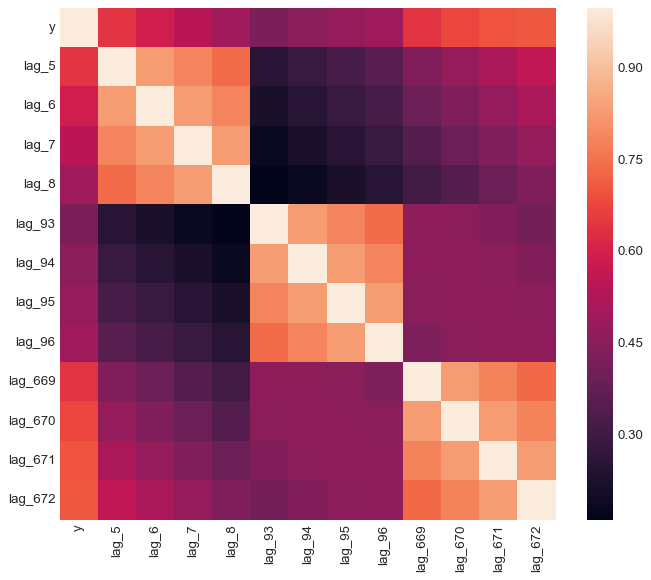

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.dropna().corr());

In [45]:
X_train, X_test = X[:-len(test)], X[-len(test):]
y_train, y_test = y[:-len(test)] , y[-len(test):]
n_forecast = len(forecast_time)
X_forecast = pd.DataFrame(index=forecast_time)
for i in range(5, 9):
    X_forecast["lag_{}".format(i)] = data.y.shift(i)[-n_forecast:].values
for i in range(93, 97):
    X_forecast["lag_{}".format(i)] = data.y.shift(i)[-n_forecast:].values
for i in range(s-3, s+1):
    X_forecast["lag_{}".format(i)] = data.y.shift(i)[-n_forecast:].values

In [46]:
rfr = RandomForestRegressor(oob_score=True, n_jobs=-1)
rfr.fit(X_train,y_train)
y_pred = pd.DataFrame(data = rfr.predict(X_train), index = y_train.index.values, columns=['Random Forest Train Prediction'])
y_test = pd.DataFrame(data = rfr.predict(X_test), index = y_test.index.values, columns=['Random Forest Test Prediction'])
y_forecast = pd.DataFrame(data = rfr.predict(X_forecast), index = X_forecast.index.values, columns=['Random Forest Next Hour Forecast'])

                     Random Forest Next Hour Forecast
2018-04-13 19:00:00                               5.2
2018-04-13 19:15:00                               6.1
2018-04-13 19:30:00                               5.4
2018-04-13 19:45:00                               4.6
1.0


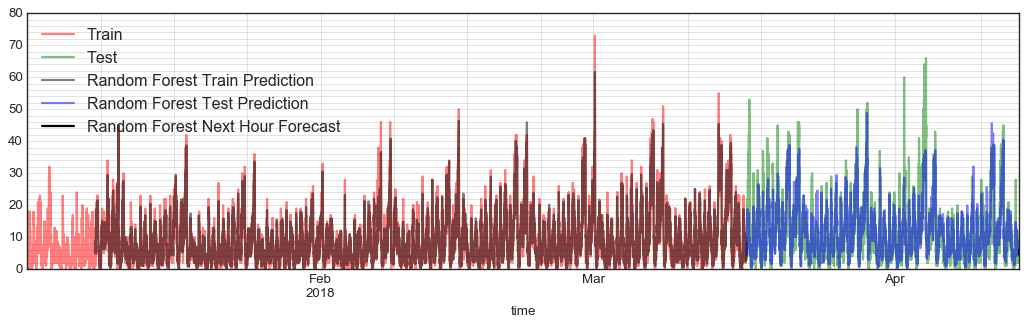

In [47]:
fig, ax = plt.subplots(figsize=(16,4))
train.rename(columns={'count':'Train'}).plot(c='red', ax=ax, alpha=.5, lw=2)
test.rename(columns={'count':'Test'}).plot(c='green', alpha=.5, ax=ax, lw=2)
y_pred.plot(c='black', alpha=0.5,ax=ax, lw=2);
y_test.plot(c='blue', alpha=0.5,ax=ax, lw=2);
y_forecast.plot(c='black', ax=ax, lw=2)
ax.minorticks_on()
plt.legend(loc='best')
plt.grid(which='both')
print y_forecast
# mse = ((y_pred.values[s:] - y.values[s:]) ** 2).mean()
# print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
print rfr.score(X_test, y_test)

#### Top ten most important features:

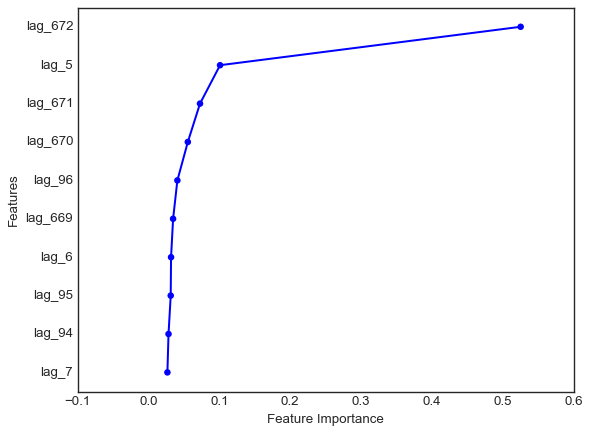

In [48]:
feature_imp = pd.DataFrame({'Feature Importance' : rfr.feature_importances_, 'Features' : X.columns})
feature_imp.sort_values(by='Feature Importance', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(8,6))
impplot = sns.pointplot(x='Feature Importance', y = 'Features', data=feature_imp.iloc[:10], ax=ax, lw=2)

#### Partial dependence of the begging activity to our features:

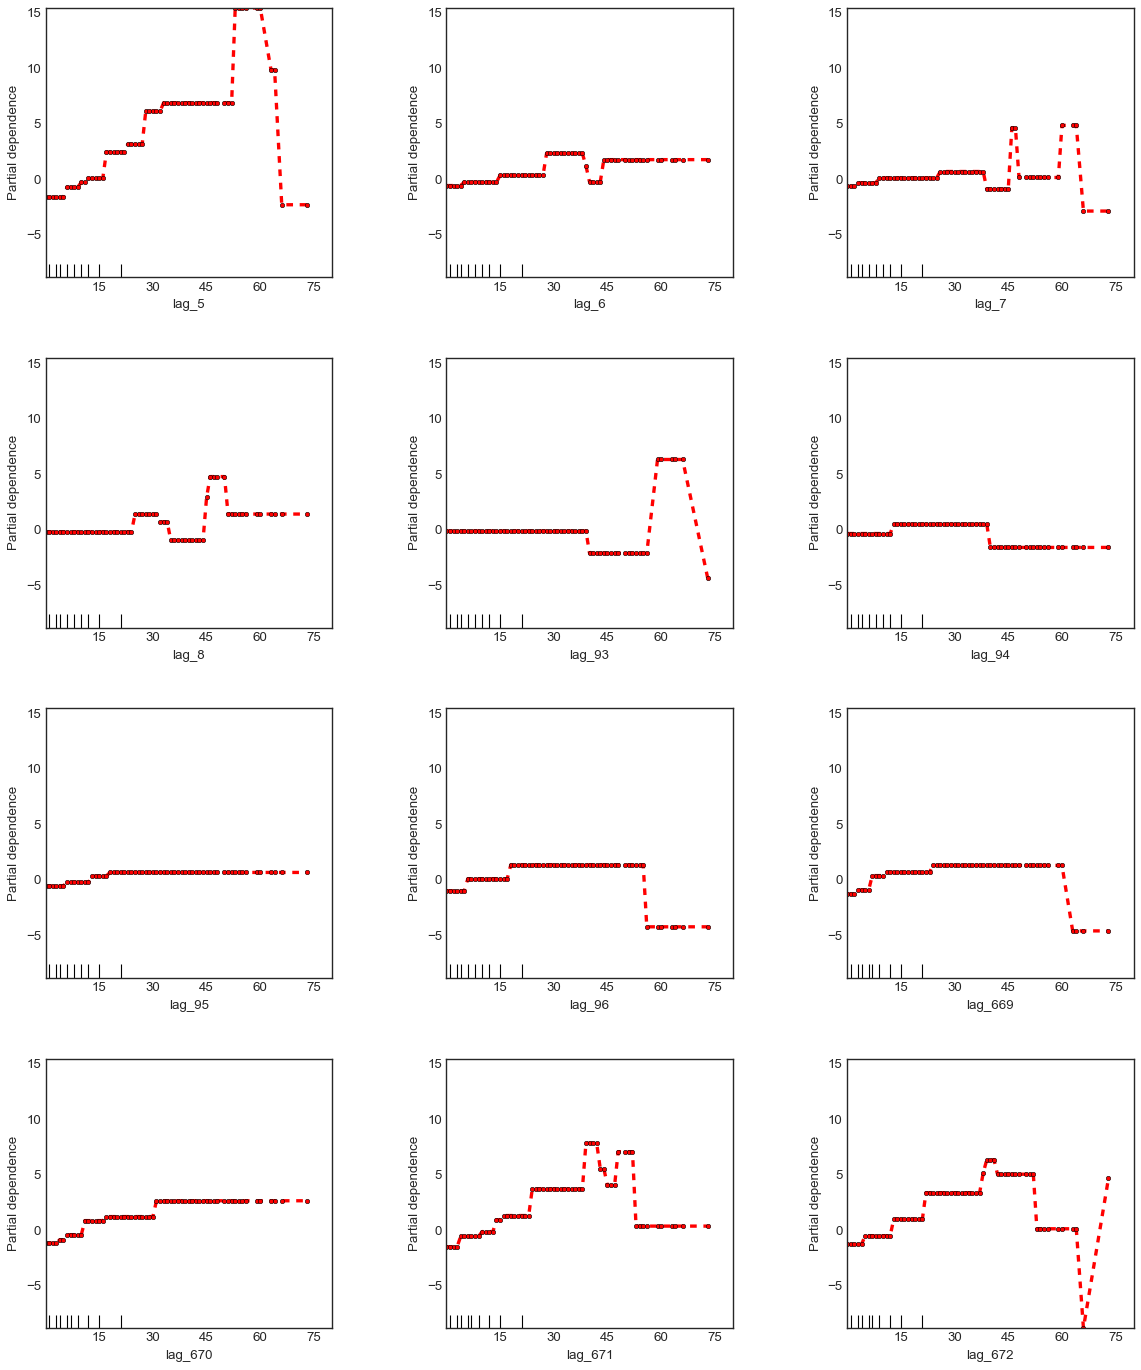

In [49]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X, y)
features = X.columns.values
names = X.columns.values
fig, axs = plot_partial_dependence(gbr, X, features, feature_names=names
                                   , n_cols=3, figsize=(16,30),
                                   line_kw={'linestyle':'--', 'marker':'o', 
                                            'color':'red', 'markersize':4,
                                            'linewidth':3
                                           })

### Conclusion:
1. Random Forest Regressor produced the most acurate predictions on our test data
2. Last week and previous hour lag activity data are the most important predictors for future activities.

In [50]:
print y_forecast

                     Random Forest Next Hour Forecast
2018-04-13 19:00:00                               5.2
2018-04-13 19:15:00                               6.1
2018-04-13 19:30:00                               5.4
2018-04-13 19:45:00                               4.6


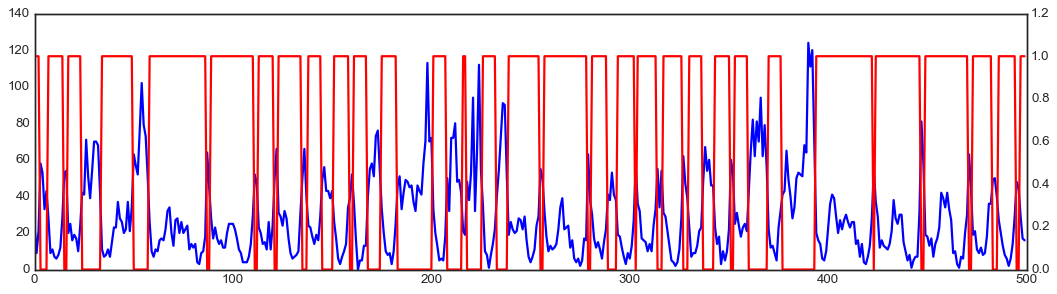

In [52]:
X = begg_1h_data['count']
X = np.column_stack([X])
model = GaussianHMM(n_components=2,random_state=1)
model.fit([X])
states = model.predict(X)
pd.Series(states).value_counts()
fig, ax1 = plt.subplots(figsize=(16,4))
ax1.plot(X[:500], lw=2);
ax2 = ax1.twinx();
plt.plot(states[:500], 'r', lw=2);
states_ybound = max(X)[0]/ax1.get_ybound()*ax2.get_ybound()
states_ybound[0] = 0
states_ybound = [0, 1.2]
ax2.set_ybound(states_ybound)